# Riffing on Analyzing Hacker News

Recently my buddy Felipe Hoffa released a notebook that showed how to analyze the Hacker News public dataset in BigQuery using a combination of BigQuery and Cloud Datalab.  [Go read it, it's brilliant stuff and a prerequisite for the notebook that follows...](https://github.com/fhoffa/notebooks/blob/master/analyzing%20hacker%20news.ipynb)

As I was trying it out, it got me thinking about differences in analysis styles and needs based on peoples' preferences and the nature of data being analyzed.  What follows it my riff on Felipe's notebook...

I spend a lot of time analyzing data, typically financial data, using a combination of BigQuery and Cloud Datalab (I also use Cloud Bigtable and Cloud Dataflow a lot as well but they're not in focus here).  If you think of how you could approach that combining exercise you could:

1. Do most processing in BigQuery and visualize the results in Cloud Datalab.
2. Do little processing in BigQuery, most processing in Cloud Datalab and visualize the results in Cloud Datalab.

Is one better than the other?  No.  The choice between the two depends on the size of the data being analyzed and the nature of the analysis being performed.  Here are some heuristics I use when choosing how to combine the two:

* If the data runs to millions of rows do it in BigQuery.  For example, I was recently analyzing 10 years of equities market data for time series anomalies and I did the processing in BigQuery because it was a LOT of data.  N.B. the back of my trusty envelope showed that at 200 bytes per market data message and several millions of messages per day this wasn't a problem to address in memory.
* If the analysis can't easily be expressed in BigQuery SQL do it in Cloud Datalab.  Taking the same example, once I had identified months in the last 10 years that seemed to show anonalous behavior I wanted to apply an online learning algorithm to drill in and find out more.  I did this in Python on Cloud Dataflow.

You'll notice that agility is not one of the metrics for choosing between BigQuery and Cloud Datalab.  That's because both - individually and in combination - allow you to build, execute, succeed, fail, and iterate as fast as you want to.

Let's start with imports and queries.

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gcp.bigquery as bq

The original query that extracts, processes and orders the data.

In [44]:
%%sql --module hn_processed

DEFINE QUERY score_per_hour
SELECT HOUR(SEC_TO_TIMESTAMP(time-3600*7)) hour, COUNT(*) stories, AVG(score) avg_score, SUM(score>30)/COUNT(*) prob
FROM [fh-bigquery:hackernews.stories] 
WHERE YEAR(time_ts)=2015
GROUP BY 1
ORDER BY 1

A new query that simply extracts the data.

In [45]:
%%sql --module hn_raw

DEFINE QUERY score_per_hour
SELECT score, time_ts
FROM [fh-bigquery:hackernews.stories] 
WHERE YEAR(time_ts)=2015

Let's get the processed data...

In [46]:
scores_processed=bq.Query(hn_processed.score_per_hour).to_dataframe()
scores_processed[:5]

,hour,stories,avg_score,prob
0,0,7185,11.121720,0.073904
1,1,7645,9.386911,0.062917
2,2,8337,9.798601,0.063092
3,3,8417,10.373439,0.067364
4,4,9735,11.415378,0.069543


If you were watching you'll have noticed that this code executed quickly in a matter of a few seconds.

Now let's get the raw data...

In [47]:
scores_raw=bq.Query(hn_raw.score_per_hour).to_dataframe()
scores_raw[:5]

,score,time_ts
0,2,2015-08-03 16:03:56
1,4,2015-08-03 16:09:01
2,73,2015-08-03 16:10:53
3,10,2015-08-03 16:14:38
4,2,2015-08-03 16:20:20


Again, if you were watching you'll have noticed that this code executed more slowly taking a few 10s of seconds.

Why is that?  Well, if you look at the queries in BigQuery both are relatively straightforward.  The first takes a few seconds and processes ~40MB of data, and the second takes a few seconds and processes ~20MB of data.  No joy there, well until you think about what is returned by the queries.  The first returns 24 rows of 4 values (96 values in total), the second returns 265956 rows of 2 values (~500,000 values in total).  It's the serialization/deserialization of the returned data that makes the difference...

In [48]:
print scores_processed.shape
print scores_raw.shape

(24, 4)
(265956, 2)


## Average Score by Hour of Day

Let's plot the average score of a story depending on the hour it was posted, using the processed dataset, using a GMT-7 timezone as in the original notebook.

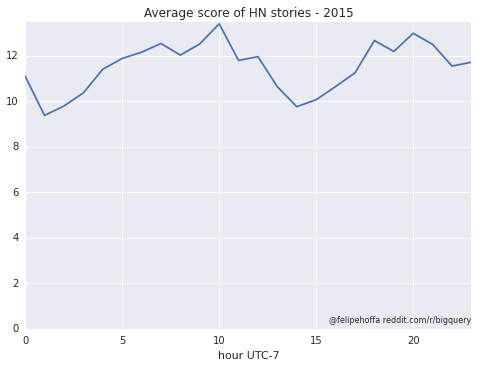

In [49]:
my_plot=scores_processed.set_index('hour')['avg_score'].plot(kind='line', title='Average score of HN stories - 2015')
my_plot.set_xlabel("hour UTC-7")
my_plot.set_ylim(ymin=0)
plt.figtext(.9,.14,'@felipehoffa reddit.com/r/bigquery', fontsize=8, ha='right')

Now let's do the same for the raw dataset...

First, let's account for the UTC-7 hour shift, then let's extract the hour of day from the raw data and group by the hour of day.

In [50]:
scores_raw['time_ts_shifted'] = scores_raw['time_ts'] - pd.Timedelta(hours=7)
scores_raw['hour_of_day_shifted'] = scores_raw['time_ts_shifted'].apply(lambda x: x.hour)

by_hour_of_day = scores_raw.groupby('hour_of_day_shifted')

We can now aggregate the data to find the average score of a post.

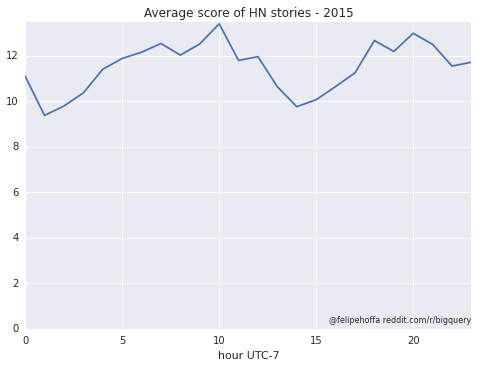

In [51]:
average_by_hour_of_day_aggregated = by_hour_of_day.aggregate([np.mean])

my_plot=average_by_hour_of_day_aggregated['score']['mean'].plot(kind='line', title='Average score of HN stories - 2015')
my_plot.set_xlabel("hour UTC-7")
my_plot.set_ylim(ymin=0)
plt.figtext(.9,.14,'@felipehoffa reddit.com/r/bigquery', fontsize=8, ha='right')

...And the plots are the same, awesome sauce...

## Optimal Hour of Day for a High Score

Let's look at the best time to post a story by calculating the probability of getting a score>30 accounting for all other stories being posted around the same time.  For the processed dataset this has already been done so we simply plot it out.

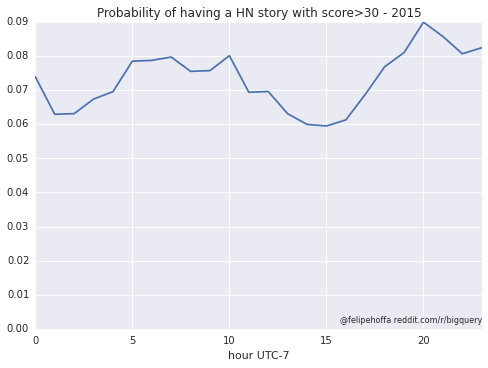

In [52]:
my_plot=scores_processed.set_index('hour')['prob'].plot(kind='line', title='Probability of having a HN story with score>30 - 2015')
my_plot.set_xlabel("hour UTC-7")
my_plot.set_ylim(ymin=0)
plt.figtext(.9,.14,'@felipehoffa reddit.com/r/bigquery', fontsize=8, ha='right')

Now let's do the same for the raw dataset...

We reuse the same grouped dataset as before and this time aggregate using a custom function we define below.

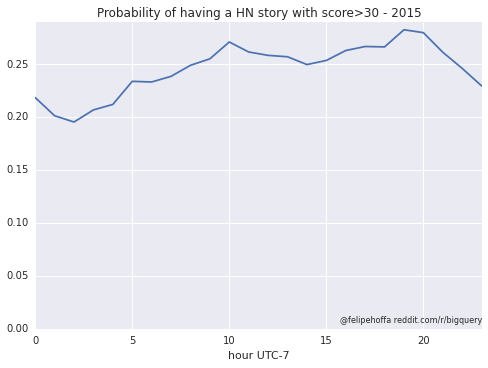

In [53]:
def probability(scores):
  return float(len(scores.values[np.where(scores.values > 3)])) / float(len(scores))

probability_by_hour_of_day = by_hour_of_day.aggregate([len, np.mean, probability])

my_plot=probability_by_hour_of_day['score']['probability'].plot(kind='line', title='Probability of having a HN story with score>30 - 2015')
my_plot.set_xlabel("hour UTC-7")
my_plot.set_ylim(ymin=0)
plt.figtext(.9,.14,'@felipehoffa reddit.com/r/bigquery', fontsize=8, ha='right')

...And the plots looks way different, rats...

It's because I made a mistake in the code.  I calculated the probability for a score above 3 rather than 30.  What you'd do in this case is change the code and rerun the cell  but for the purposes of completeness I've repeated the corrected code below.

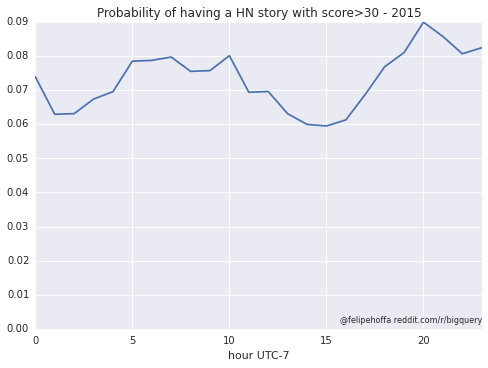

In [54]:
def probability(scores):
  return float(len(scores.values[np.where(scores.values > 30)])) / float(len(scores))

probability_by_hour_of_day = by_hour_of_day.aggregate([len, np.mean, probability])

my_plot=probability_by_hour_of_day['score']['probability'].plot(kind='line', title='Probability of having a HN story with score>30 - 2015')
my_plot.set_xlabel("hour UTC-7")
my_plot.set_ylim(ymin=0)
plt.figtext(.9,.14,'@felipehoffa reddit.com/r/bigquery', fontsize=8, ha='right')

...And they now look the same, and the sauce is again awesome...

## Conclusions

There are many ways to peel an orange and this notebook was intended to illustrate two, not to say one was better than the other, but is one better than the other?

Yes, for the strict purposes of this notebook I'd go the BigQuery route because it avoids the serialization/deserialization delay for the dataset and rips...

And yes, for the purposes of some additional analysis I'm looking at for some machine learning on the dataset (to see if we can dive deeper than just picking the optimal hour of day) I'd go the Python route because I can query for a superset of data and then slice-and-dice to my heart's content in Python with scikit learn.

So, yes and yes...

In [55]:
"""
	Copyright 2015, Google, Inc.
 Licensed under the Apache License, Version 2.0 (the "License");
 you may not use this file except in compliance with the License.
 You may obtain a copy of the License at
    http://www.apache.org/licenses/LICENSE-2.0
 Unless required by applicable law or agreed to in writing, software
 distributed under the License is distributed on an "AS IS" BASIS,
 WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 See the License for the specific language governing permissions and
 limitations under the License.
"""

'\n\tCopyright 2015, Google, Inc.\n Licensed under the Apache License, Version 2.0 (the "License");\n you may not use this file except in compliance with the License.\n You may obtain a copy of the License at\n    http://www.apache.org/licenses/LICENSE-2.0\n Unless required by applicable law or agreed to in writing, software\n distributed under the License is distributed on an "AS IS" BASIS,\n WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.\n See the License for the specific language governing permissions and\n limitations under the License.\n'